<h1><center> Assignment 3 </center> </h1>

<h2 style="text-align:left;">
    Name: Sushovan Jena
    <span style="float:right;">
        Course: CS669
    </span>
</h2>
<h2 style="text-align:left;">
    Enroll No.: S20011
    <span style="float:right;">
         (Pattern Recognition)
    </span>
</h2>


In [206]:
### Imported the required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score


<h2> Implementation of GMM Clustering Algorithm </h2>

In [207]:
### Implementation of GMM
class GMM:
    def __init__(self, K, n_iter):
        ### K = number of clusters and n_iter = iteration number
        self.K = K
        self.n_iter = n_iter
        
    ### Function to calculate mean and covariance matrix 
    ### prediction: cluster labels from k-means, X: N*d numpy array data points 
    def calculate_mean_covariance(self, X, prediction):
        ### Data dimension
        d = X.shape[1]
        labels = np.unique(prediction)
        ### Iitialize means, covariance, and prior of each cluster
        self.initial_means = np.zeros((self.K, d))
        self.initial_cov = np.zeros((self.K, d, d))
        self.initial_pi = np.zeros(self.K)
        
        counter=0
        ### Perform for each classes
        for label in labels:
            ### Get indices
            ids = np.where(prediction == label)
            ### Calculate the initial prior prob
            self.initial_pi[counter] = len(ids[0]) / X.shape[0]
            ### Calculate the initial mean
            self.initial_means[counter,:] = np.mean(X[ids], axis = 0)
            diff_mean = X[ids] - self.initial_means[counter,:]
            ### Number of data points in current cluster
            Nk = X[ids].shape[0]
            ### Calculate the initial covariance matrix
            self.initial_cov[counter,:, :] = np.dot(self.initial_pi[counter] * diff_mean.T, diff_mean) / Nk
            counter+=1
            
        return (self.initial_means, self.initial_cov, self.initial_pi)
    
    
    ### Initialize the parameters
    def initialise_parameters(self, X):
        n_clusters = self.K
        kmeans = KMeans(n_clusters= n_clusters, max_iter=500, algorithm = 'auto')
        fitted = kmeans.fit(X)
        prediction = kmeans.predict(X)
        self.initial_means, self.initial_cov, self.initial_pi = self.calculate_mean_covariance(X, prediction)
        
        return (self.initial_means, self.initial_cov, self.initial_pi)
            
        
    ### Implementation of Expectation Step (E-Step)    
    def E_Step(self, X, pi, mu, sigma):
        N = X.shape[0] 
        self.gamma = np.zeros((N, self.K))
        for c in range(self.K):
            ### Posterior prob using Bayes Rule
            self.gamma[:,c] = self.pi[c] * multivariate_normal.pdf(X, self.mu[c,:], self.sigma[c])

        ### normalize across columns to make a valid probability
        gamma_norm = np.sum(self.gamma, axis=1)[:,np.newaxis]
        self.gamma /= gamma_norm
        
        return self.gamma
    
    ### Implementation of Maximization Step (M-Step)
    def M_Step(self, X, gamma):
        ### number of data points
        N = X.shape[0]
        ### Number of cluster
        C = self.gamma.shape[1]
        ### Dimension of data
        d = X.shape[1]

        ### Update Prior (pi), mean 
        self.pi = np.mean(self.gamma, axis = 0)
        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis = 0)[:,np.newaxis]
        ### Update covariance matrix
        for c in range(C):
            diff_mean = X - self.mu[c, :]
            gamma_diag = np.diag(self.gamma[:,c])
            ### Convert mean and gamma to matrix for multiplication
            x_mu = np.matrix(diff_mean)
            gamma_diag = np.matrix(gamma_diag)
            ### Calculation Covariance Matrix (sigma)
            sigma_c = diff_mean.T * gamma_diag * diff_mean
            self.sigma[c,:,:]=(sigma_c) / np.sum(self.gamma, axis = 0)[:,np.newaxis][c]

        return self.pi, self.mu, self.sigma 
    
    ### Function to train the parameters
    def training(self, X):
        d = X.shape[1]
        self.mu, self.sigma, self.pi =  self.initialise_parameters(X)
        ### Repeat the following (E and M Step) for n_iter
        for run in range(self.n_iter):  
            self.gamma  = self.E_Step(X, self.mu, self.pi, self.sigma)
            self.pi, self.mu, self.sigma = self.M_Step(X, self.gamma)
            
        return self
    
    ### Function to predict the cluster labels
    def predict(self, X):
        labels = np.zeros((X.shape[0], self.K))
        ### For each cluster
        for c in range(self.K):
            labels [:,c] = self.pi[c] * multivariate_normal.pdf(X, self.mu[c,:], self.sigma[c])
        labels  = labels .argmax(1)
        return labels 
    
    ### Function to get the probability of belonging to each cluster
    def predict_proba(self, X):
        posterier_prob = np.zeros((X.shape[0], self.K))
        
        for c in range(self.K):
            # Posterior probability using Bayes Rule
            posterier_prob[:,c] = self.pi[c] * multivariate_normal.pdf(X, self.mu[c,:], self.sigma[c])
    
        return posterier_prob


<h2> Using the GMM clustering algorithm for the classification of non-separable data from Assignment-1</h2>

Classification Accuracy = 100.0%



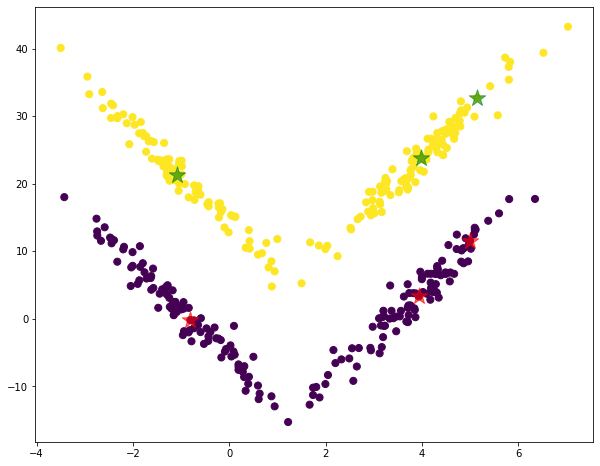

In [208]:
path = "D:/Sujeet_PhD/Course_Work/Pattern Recognition/Assignment/Assignment-2/nls_data/"

files = []
for file in os.listdir(path):
    if file.endswith(".txt"):
        files.append(os.path.join(path, file))
# print(path)
# print(files)

## Split  the training and tesing data ##
def get_data(dataset):
    train = dataset.sample(frac=0.80, random_state=100)
    test = dataset[~dataset.index.isin(train.index)]
    return train, test

trainl_data = pd.DataFrame(columns=['X', 'Y', 'label'])
testl_data = pd.DataFrame(columns=['X', 'Y', 'label'])
alldata_l = pd.DataFrame(columns=['X', 'Y', 'label'])
for file, i in zip(files, range(len(files))):
    data = pd.read_csv(file, header=None)
    data.rename(columns = {0:'X', 1:'Y'}, inplace = True)
    data['label'] = [i for _ in range(data.shape[0])]
    data=data.sample(frac=1).reset_index(drop=True)
    ### Split data in training and test dataset
    temp_train, temp_test = get_data(data)
    trainl_data = trainl_data.append(temp_train)
    testl_data = testl_data.append(temp_test)
    alldata_l = alldata_l.append(data)


train_c1 = trainl_data[trainl_data.label==0].drop(labels='label', axis=1)
train_c1 = train_c1.to_numpy()

train_c2 = trainl_data[trainl_data.label==1].drop(labels='label', axis=1)
train_c2 = train_c2.to_numpy()

test_data = testl_data.drop(labels='label', axis=1)
test_data = test_data.to_numpy()


model1 = GMM(3, n_iter = 50)
model2 = GMM(3, n_iter = 50)

fitted_values_c1 = model1.training(train_c1)
predicted_values_c1 = model1.predict(test_data)
predicted_prob_c1 = np.max(model1.predict_proba(test_data), axis=1)
# predicted_prob_c11 = np.sum(model1.predict_proba(test_data), axis=1)

fitted_values_c2 = model2.training(train_c2)
predicted_values_c2 = model2.predict(test_data)
predicted_prob_c2 = np.max(model2.predict_proba(test_data), axis=1)
# predicted_prob_c21 = np.sum(model2.predict_proba(test_data), axis=1)

final_prediction = [0 if predicted_prob_c1[i] > predicted_prob_c2[i] else 1 for i in range(len(test_data))]
# final_prrdiction1 = [0 if predicted_prob_c11[i] > predicted_prob_c21[i] else 1 for i in range(len(test_data))]

print("Classification Accuracy = {}%\n".format(accuracy_score(list(testl_data['label']), final_prediction)*100))
# print(accuracy_score(list(testl_data['label']), final_prediction1)*100)

### Plot the test data with classification and assigned centers
centers1 = np.zeros((3,2))
centers2 = np.zeros((3,2))
for i in range(model1.K):
    density1 = multivariate_normal(cov=model1.sigma[i], mean=model1.mu[i]).logpdf(test_data)
    centers1[i, :] = test_data[np.argmax(density1)]
    density2 = multivariate_normal(cov=model2.sigma[i], mean=model2.mu[i]).logpdf(test_data)
    centers2[i, :] = test_data[np.argmax(density2)]
    
plt.figure(figsize = (10,8))
plt.scatter(test_data[:, 0], test_data[:, 1],c=final_prrdiction ,s=50, zorder=1)

plt.scatter(centers1[:, 0], centers1[:, 1],c='red', marker='*', s=300, alpha=0.6, zorder=2);
plt.scatter(centers2[:, 0], centers2[:, 1],c='green', marker='*', s=300, alpha=0.6, zorder=2);


<h2> Using the GMM clustering algorithm for the classification of another set of non-seperable data (with 2000 points in each class)</h2>

Classification Accuracy = 100.0%



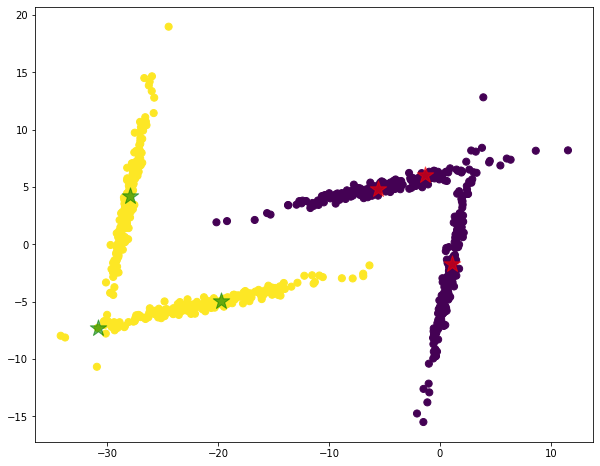

In [193]:
path = "D:/Sujeet_PhD/Course_Work/Pattern Recognition/Assignment/Assignment3/Assignment_3/data_1/"

files = []
for file in os.listdir(path):
    if file.endswith(".txt"):
        files.append(os.path.join(path, file))
# print(path)
# print(files)

## Split  the training and tesing data ##
def get_data(dataset):
    train = dataset.sample(frac=0.80, random_state=100)
    test = dataset[~dataset.index.isin(train.index)]
    return train, test

trainl_data = pd.DataFrame(columns=['X', 'Y', 'label'])
testl_data = pd.DataFrame(columns=['X', 'Y', 'label'])
alldata_l = pd.DataFrame(columns=['X', 'Y', 'label'])
for file, i in zip(files, range(len(files))):
    data = pd.read_csv(file, header=None)
    data.rename(columns = {0:'X', 1:'Y'}, inplace = True)
    data['label'] = [i for _ in range(data.shape[0])]
    data=data.sample(frac=1).reset_index(drop=True)
    ### Split data in training and test dataset
    temp_train, temp_test = get_data(data)
    trainl_data = trainl_data.append(temp_train)
    testl_data = testl_data.append(temp_test)
    alldata_l = alldata_l.append(data)


train_c1 = trainl_data[trainl_data.label==0].drop(labels='label', axis=1)
train_c1 = train_c1.to_numpy()

train_c2 = trainl_data[trainl_data.label==1].drop(labels='label', axis=1)
train_c2 = train_c2.to_numpy()

test_data = testl_data.drop(labels='label', axis=1)
test_data = test_data.to_numpy()


model1 = GMM(3, n_iter = 50)
model2 = GMM(3, n_iter = 50)

fitted_values_c1 = model1.training(train_c1)
predicted_values_c1 = model1.predict(test_data)
predicted_prob_c1 = np.max(model1.predict_proba(test_data), axis=1)
# predicted_prob_c11 = np.sum(model1.predict_proba(test_data), axis=1)

fitted_values_c2 = model2.training(train_c2)
predicted_values_c2 = model2.predict(test_data)
predicted_prob_c2 = np.max(model2.predict_proba(test_data), axis=1)
# predicted_prob_c21 = np.sum(model2.predict_proba(test_data), axis=1)

final_prrdiction = [0 if predicted_prob_c1[i] > predicted_prob_c2[i] else 1 for i in range(len(test_data))]
# final_prrdiction1 = [0 if predicted_prob_c11[i] > predicted_prob_c21[i] else 1 for i in range(len(test_data))]

print("Classification Accuracy = {}%\n".format(accuracy_score(list(testl_data['label']), final_prrdiction)*100))
# print(accuracy_score(list(testl_data['label']), final_prrdiction1)*100)

### Plot the test data with classification and assigned centers
centers1 = np.zeros((3,2))
centers2 = np.zeros((3,2))
for i in range(model1.K):
    density1 = multivariate_normal(cov=model1.sigma[i], mean=model1.mu[i]).logpdf(test_data)
    centers1[i, :] = test_data[np.argmax(density1)]
    density2 = multivariate_normal(cov=model2.sigma[i], mean=model2.mu[i]).logpdf(test_data)
    centers2[i, :] = test_data[np.argmax(density2)]
    
plt.figure(figsize = (10,8))
plt.scatter(test_data[:, 0], test_data[:, 1],c=final_prrdiction ,s=50, zorder=1)

plt.scatter(centers1[:, 0], centers1[:, 1],c='red', marker='*', s=300, alpha=0.6, zorder=2);
plt.scatter(centers2[:, 0], centers2[:, 1],c='green', marker='*', s=300, alpha=0.6, zorder=2);